In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OrdinalEncoder
import joblib
from sklearn.linear_model import LinearRegression
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression,  RandomForestRegressor, GBTRegressor
import matplotlib.pyplot as plt
from pyspark.ml.classification import LogisticRegression

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler, VectorIndexer
from xgboost.spark import SparkXGBRegressor
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


In [4]:
spark = SparkSession.builder.appName("StudentGPA").getOrCreate()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/09 11:32:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [35]:
df = spark.read.csv("/DoAn/Raw_Dataset_Knn.csv", header=True, inferSchema=True)


Linear Regression

In [36]:
feature_cols = ['namsinh','gioitinh','dtbhk_1','dtbhk_2','dtbhk_3','dtbhk_4','dtbhk_5','dtbhk_6','dtbhk_7']

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

data = assembler.transform(df).select("features", "dtbhk_8")

train_df, test_df = data.randomSplit([0.8, 0.2], seed=40)

lr = LinearRegression(featuresCol="features", labelCol="dtbhk_8",
                      regParam=0.1, elasticNetParam=0.5)  
lr_model = lr.fit(train_df)
prediction = lr_model.transform(test_df)

prediction.select("features", "dtbhk_8", "prediction").show()


+--------------------+-------+------------------+
|            features|dtbhk_8|        prediction|
+--------------------+-------+------------------+
|[0.0,-1.0,1.75,3....|   6.38| 4.733779867758156|
|[0.0,-1.0,1.92,3....|   4.97|5.5621774727556454|
|[0.0,-1.0,2.39,3....|   4.44| 4.657814859997409|
|[0.0,-1.0,2.45,0....|   5.06| 4.329534220935121|
|[0.0,-1.0,2.46,2....|   3.12| 4.484130937329561|
|[0.0,-1.0,2.51,1....|    5.6| 3.617560932548696|
|[0.0,-1.0,2.67,1....|   4.44| 3.014052143906518|
|[0.0,-1.0,2.91,6....|   6.57| 6.185117038480373|
|[0.0,-1.0,2.94,2....|   3.42|3.9859659037091566|
|[0.0,-1.0,3.53,3....|   4.65| 4.179678141536671|
|[0.0,-1.0,3.53,3....|    5.0| 5.487753400378497|
|[0.0,-1.0,3.64,3....|    2.1|4.5113446394216625|
|[0.0,-1.0,3.71,2....|   6.45| 6.897043657152527|
|[0.0,-1.0,3.73,4....|   2.02| 2.329012163780356|
|[0.0,-1.0,4.0,1.6...|   3.51|3.3994021177151845|
|[0.0,-1.0,4.12,2....|   7.15|7.3259756361542925|
|[0.0,-1.0,4.12,3....|   5.05|3.9627229385847595|


In [37]:
summary = lr_model.summary
print("RMSE:", summary.rootMeanSquaredError)
print("R2:", summary.r2)
print("MSE:", summary.meanSquaredError)
print("MAE:", summary.meanAbsoluteError)

RMSE: 1.1039581291967941
R2: 0.6340318976898516
MSE: 1.2187235510196859
MAE: 0.7746812422480976


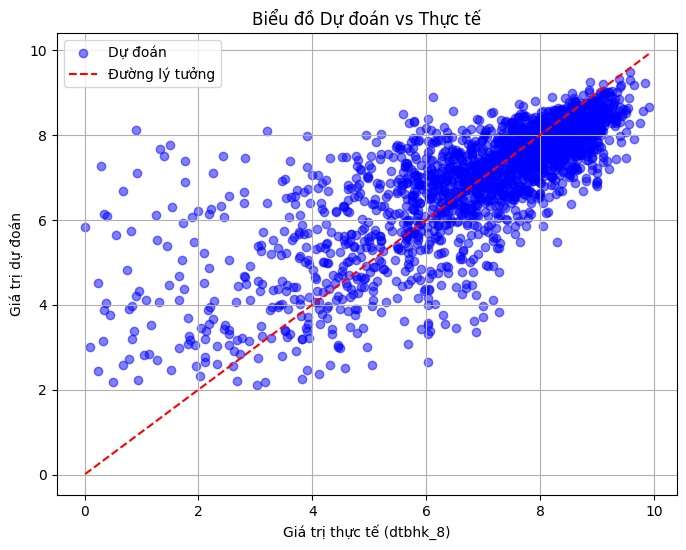

In [38]:
pred_df = prediction.select("dtbhk_8", "prediction").toPandas()
plt.figure(figsize=(8,6))
plt.scatter(pred_df["dtbhk_8"], pred_df["prediction"], alpha=0.5, color='blue', label='Dự đoán')
plt.plot([pred_df["dtbhk_8"].min(), pred_df["dtbhk_8"].max()],
         [pred_df["dtbhk_8"].min(), pred_df["dtbhk_8"].max()],
         color='red', linestyle='--', label='Đường lý tưởng')

plt.xlabel("Giá trị thực tế (dtbhk_8)")
plt.ylabel("Giá trị dự đoán")
plt.title("Biểu đồ Dự đoán vs Thực tế")
plt.legend()
plt.grid(True)
plt.show()


Linear Regression with Cross validation

In [41]:
feature_cols = ['namsinh','gioitinh','dtbhk_1','dtbhk_2','dtbhk_3','dtbhk_4','dtbhk_5','dtbhk_6','dtbhk_7']
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
data = assembler.transform(df).select("features", "dtbhk_8")
lr = LinearRegression(featuresCol="features", labelCol="dtbhk_8",
                      regParam=0.1, elasticNetParam=0.5)  
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.05, 0.1, 0.3, 0.5]) \
    .addGrid(lr.elasticNetParam, [0, 0.3, 0.5, 0.7, 1.0]) \
    .addGrid(lr.maxIter, [10, 50, 100]) \
    .build()
evaluator = RegressionEvaluator(labelCol="dtbhk_8", predictionCol="prediction", metricName="rmse")
cv = CrossValidator(estimator=lr,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator,
                    numFolds=5)  # 5-fold cross-validation
cv_model = cv.fit(data)
best_model = cv_model.bestModel
print("Best regParam:", best_model._java_obj.getRegParam())
print("Best elasticNetParam:", best_model._java_obj.getElasticNetParam())
predictions = best_model.transform(data)
predictions.select("dtbhk_8", "prediction").show()
summary = best_model.summary
print("RMSE:", summary.rootMeanSquaredError)
print("R2:", summary.r2)
print("MSE:", summary.meanSquaredError)
print("MAE:", summary.meanAbsoluteError)
best_model.save("/spark_model/linear_logistic")


Best regParam: 0.01
Best elasticNetParam: 0.0
+-------+------------------+
|dtbhk_8|        prediction|
+-------+------------------+
|   7.93| 7.965104729873942|
|   8.83| 8.543149671551562|
|    7.8| 7.574387801135183|
|   7.24| 7.993184389880211|
|   8.05| 8.228173425005442|
|   8.81| 8.322679264313017|
|   9.03| 8.038028636234944|
|   5.04| 4.843234102398596|
|   4.93| 4.947012736850445|
|   8.55| 8.790394980542104|
|   8.68| 7.494706263786021|
|   5.05| 4.604757283263427|
|   3.48|3.6347349961736493|
|   0.86|2.9864166889090082|
|   8.62| 8.784575607072899|
|    2.7| 3.681873054236208|
|   5.66| 7.684204464590467|
|   8.53| 8.137775981672549|
|    8.7|  8.48531145166431|
|   4.49| 4.924249919341359|
+-------+------------------+
only showing top 20 rows

RMSE: 1.1099257379605838
R2: 0.6310765783740412
MSE: 1.2319351437873465
MAE: 0.772659402252449


Random Forest

In [46]:
feature_cols = ['namsinh','gioitinh','dtbhk_1','dtbhk_2','dtbhk_3','dtbhk_4','dtbhk_5','dtbhk_6','dtbhk_7']
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
assembled_data = assembler.transform(df)

# (Tùy chọn) Chuẩn hóa nếu muốn
# scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)
# scaled_data = scaler.fit(assembled_data).transform(assembled_data)

# Bước 2: Dữ liệu train/test
data = assembled_data.select("features", "dtbhk_8")
train_df, test_df = data.randomSplit([0.8, 0.2], seed=42)

# Bước 3: Random Forest Regressor
rf = RandomForestRegressor(featuresCol="features", labelCol="dtbhk_8", numTrees=100, maxDepth=5)
rf_model = rf.fit(train_df)

# Bước 4: Dự đoán
predictions = rf_model.transform(test_df)

# Bước 5: Đánh giá
evaluator = RegressionEvaluator(labelCol="dtbhk_8", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predictions)

rmse = RegressionEvaluator(labelCol="dtbhk_8", predictionCol="prediction", metricName="rmse").evaluate(predictions)
mae = RegressionEvaluator(labelCol="dtbhk_8", predictionCol="prediction", metricName="mae").evaluate(predictions)

print(f"R2: {r2}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")



R2: 0.6332455501411929
RMSE: 1.1158467093242395
MAE: 0.7726200417757083


Gradient Boosted Tree

In [29]:
feature_cols = ['namsinh','gioitinh','dtbhk_1','dtbhk_2','dtbhk_3','dtbhk_4','dtbhk_5','dtbhk_6','dtbhk_7']

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

data = assembler.transform(df).select("features", "dtbhk_8")

train_df, test_df = data.randomSplit([0.8, 0.2], seed=40)

gbt = GBTRegressor(featuresCol="features", labelCol="dtbhk_8", maxIter=100)
gbt_model = gbt.fit(train_df)
gbt_prediction = gbt_model.transform(test_df)

gbt_prediction.select("features", "dtbhk_8", "prediction").show()
evaluator = RegressionEvaluator(labelCol="dtbhk_8", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(gbt_prediction)

rmse = RegressionEvaluator(labelCol="dtbhk_8", predictionCol="prediction", metricName="rmse").evaluate(gbt_prediction)
mae = RegressionEvaluator(labelCol="dtbhk_8", predictionCol="prediction", metricName="mae").evaluate(gbt_prediction)

print(f"R2: {r2}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")



+--------------------+-------+------------------+
|            features|dtbhk_8|        prediction|
+--------------------+-------+------------------+
|[0.0,-1.0,1.75,3....|   6.38| 5.448879413654358|
|[0.0,-1.0,1.92,3....|   4.97| 5.014327986203086|
|[0.0,-1.0,2.39,3....|   4.44| 4.254420094901856|
|[0.0,-1.0,2.45,0....|   5.06| 5.410129376578747|
|[0.0,-1.0,2.46,2....|   3.12|  5.13412123540393|
|[0.0,-1.0,2.51,1....|    5.6| 5.478771965147534|
|[0.0,-1.0,2.67,1....|   4.44| 4.197727224224477|
|[0.0,-1.0,2.91,6....|   6.57|7.1894002518602536|
|[0.0,-1.0,2.94,2....|   3.42|3.6088704802075817|
|[0.0,-1.0,3.53,3....|   4.65|3.4987050176393746|
|[0.0,-1.0,3.53,3....|    5.0|  6.05017411252384|
|[0.0,-1.0,3.64,3....|    2.1|3.2698790337523134|
|[0.0,-1.0,3.71,2....|   6.45| 6.867580297370542|
|[0.0,-1.0,3.73,4....|   2.02|2.9371397806438515|
|[0.0,-1.0,4.0,1.6...|   3.51|3.0533650546121236|
|[0.0,-1.0,4.12,2....|   7.15| 6.521005748908099|
|[0.0,-1.0,4.12,3....|   5.05| 2.975704799146808|


XGboost

In [52]:
import pandas as pd
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

pdf = df.toPandas()  # convert từ PySpark về Pandas

X = pdf[['namsinh','gioitinh','dtbhk_1','dtbhk_2','dtbhk_3','dtbhk_4','dtbhk_5','dtbhk_6','dtbhk_7']]
y = pdf['dtbhk_8']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBRegressor(objective='reg:squarederror', max_depth=5, eta=0.1, n_estimators=100)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("R2 score:", r2_score(y_test, y_pred))


R2 score: 0.6661623857248171


25/05/09 14:13:42 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


===== Model Performance on Test Data =====
RMSE: 1.1287495773230236
R2: 0.6247147294773217
MAE: 0.7803581851943993
Best regParam: 0.01
Best elasticNetParam: 0.3
Best solver: auto

Feature Importance:
dtbhk_7: 0.40661441968721507
weight_recent: 0.3099644232078707
dtbhk_6: 0.2793775047062193
dtbhk_7_squared: 0.20544416872180474
dtbhk_4: 0.17336524195484027
dtbhk_1: -0.0976246113366174
dtbhk_5: 0.09630580708760615
dtbhk_3: 0.08005580228403926
avg_dtb: 0.07435510245207887
namsinh: -0.02240910896354245
gioitinh: -0.007641724961361268
dtbhk_2: 0.0
trend: 0.0
rec_trend: 0.0
